# Modified Digit Categorization Using Generated Images
*David Cottrell(david.cottrell2@mail.mcgill.ca), Eric Quinn(eric.quinn@mail.mcgill.ca), Kelley Zhao(kelley.zhao@mail.mcgill.ca)*

Extra scripts and data can be found at github.com/dcottr/ml_proj3

## Introduction
We were given a task of categorizing a modified MNIST dataset. To do so we explored different machine learning algorithms (linear regression, SVM, and FFNN). We wished to compare these to the algorithm we expect to outperform all of them, Convoluted Neural Nets.

We explored using prior knowledge of how the dataset was generated to grow our training set into a larger one to improve the CNN's performance.


## Data Pre-processing
We know the Modified Digits dataset is an MNIST with modifications to it, including random rotations. We attempt to exploit this fact by having our learner train not only on the given dataset, but also on random rotations of it.

For our Convolutional Neural Network algorithm, we tested both leaving the data in its original form and creating these new examples by rotating original ones. For each example, we created new examples by rotating it by a random amount, and filling in the triangular gaps from rotation with a reflection of the image. The code below shows an example being rotated a random amount--as you can see the reflection mostly reflects the noise patterns in the original image, giving us a new image example we might expect.

Original:


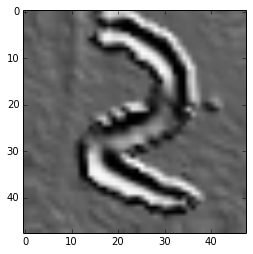

Rotated 274 degrees:


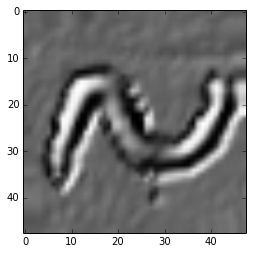

In [2]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import random
import scipy.ndimage as ndimage

# Load image of a 2
img = np.load('img/image2.npy')

# Show original
print "Original:"
plt.imshow(img, cmap="Greys_r")
plt.show()

# Show randomly rotated with reflection
angle = random.randint(1, 359)
print "Rotated " + str(angle) + " degrees:"
rotated = ndimage.interpolation.rotate(img, angle, reshape = False, order = 1, mode = "reflect")
plt.imshow(rotated, cmap="Greys_r")
plt.show()


## Feature Selection
For our first two algorithms, logistic regression and linear SVM, we used PCA to reduce the feature space by half using scikit-learn's implementation[1]. For our neural nets however we do not, since feature selection is built into the weight selections of hidden layers.

## Algorithms
### Logistic Regression
Our first approach to classifying our data was a logistic regression algorithm, using a library from sklearn[1].


In [ ]:
from sklearn import linear_model
from sklearn.decomposition import PCA

X = np.load('../data/train_inputs.npy')
Y = np.load('../data/train_outputs.npy')
test_X = np.load('../data/test_inputs.npy')
test_Y = np.load('../data/test_outputs.npy')

pca = PCA(n_components=1000)
pca.fit(X)
pca_train_X = pca.transform(X)
pca_test_X = pca.transform(Y)
clf = linear_model.LogisticRegression() # Create a Logistic Regression Classifier
clf.fit_transform(pca_train_X, Y)
accuracy_score(test_Y, clf.predict(pca_test_X))

### Linear Support Vector Machine
Our second approach was to use an linear SVM to classify the images, using sklearn's LinearSVC from sklearn[1].


In [ ]:
from sklearn import svm

X = np.load('../data/train_inputs.npy')
Y = np.load('../data/train_outputs.npy')
test_X = np.load('../data/test_inputs.npy')
test_Y = np.load('../data/test_outputs.npy')
pca = PCA(n_components=1000)
pca.fit(X)
pca_train_X = pca.transform(X)
pca_test_X = pca.transform(Y)
clf = svm.LinearSVC() # Create a Support Vector Classifier
clf.fit_transform(pca_train_X, Y)
accuracy_score(test_Y, clf.predict(pca_test_X))


### Feedforward Neural Network
Next, we used a fully connected feedforward neural net classifier we implemented from scratch.  The neural network propagates predictions forward and then error signals backwards in order to perform weight updates to get optimal predictions.  Below we show the fundamental parts of this classifier implemented in matrix form since this optimizes run times. Assume each layer i in the net has a weight matrix $W_{i}$, delta matrix $\delta_{i}$ representing the error signal, neuron matrix $N_{i}$ representing the nodes, derivative matrix $D_{i}$, and transformed matrix $T$.  

#### Forward Pass
In the forward pass of the algorithm, we are only concerned about the weight, neuron, and transformed matrix where the transformed matrix is the standard sigmoid function applied to each element in the neuron matrix:

<center>$f_{\sigma}(N) = T$</center>

In the forward pass of the algorithm, we want the propagate the inputs through the layer by multiplying by weights and we get exactly that through:

<center>$T_{i-1}W_{i-1} = N_{i}$</center>

Furthermore, we update $D_{i}$ = $f'_{\sigma}(N_{i})$ during this step since we will need them in the backwards pass.

#### Backward Pass
In the backward pass of the algorithm, we want the propagate the error signal backwards and update all the weights using $D$, $\delta$ and $W$.  We chose to use a softmax function at the end of our neural net because it tends to do better in multinomial classification problems.  The derivative of the loss of the softmax function is simply:

<center>$\delta_n = y_{predictions} - y_{labels}$</center>

Now to propagate a error signal $e$ backwards for a particular node j, we want:

<center>$e_{j} = f'_{\sigma}(j)\sum_{k\in output(j)} e_{k}w_{j}$</center>

To do this, we notice that we need to take the transpose of $\delta$ and dot product it with the weight matrix and finally broadcast the derivative onto this product:

<center>$\delta_{i-1} = f'_{\sigma}(i) * W_{i}\cdot\delta_{i}^{T}$</center>

#### Weight Updates
For weights going from layer $i-1$ to layer $i$, we want to update by multiplying the relevant error signals by their respective neurons so we can do this by:

<center>$W_{i} = \alpha(\delta_{i}T_{i-1})^{T}$</center>

where $\alpha$ is the learning rate.

Below we show the implementations of the algorithms stated above:

In [ ]:
def forward(self, training):
    self.layers[0].transformed = training #self.layers is an array of the layers
    for i in range(self.size - 1):
        self.layers[i + 1].neurons = self.layers[i].forward() #forward applies TW
    return self.layers[-1].forward()

def backward(self, transformed, labels):
    self.layers[-1].deltas = (transformed - labels).T 
    for i in range(self.size - 2, 0, -1):
        nobias = self.layers[i].weights[0:-1, :] #Don't need to handle the bias, as the bias = delta
        self.layers[i].deltas = nobias.dot(self.layers[i + 1].deltas) * self.layers[i].derivative

def update_weights(self, eta):
    for i in range(0, self.size-1):
        W_grad = -alpha*(self.layers[i+1].deltas.dot(self.layers[i].transformed)).T      
        self.layers[i].weights += W_grad

### Convolutional Neural Network

One of the best ways currently known to do image recognition is to use a convolutional neural network, which uses convolution kernels in order to identify features in images. The state of the art papers on identifying handwritten digits use convolutional neural networks to do so. [2]

#### Library

We decided to use the PDNN library from Yajie Miao to do our networks. [3] This library allows for use of the CPU or GPU to do the processing, which is useful when moving between authors' computers. In addition, it has setups built in to create convolutional neural networks. This allows for more time to be spent training and working with the data instead of creating the network by hand.

#### Initial CPU Run

We did an initial training using the entirety of the unrotated images given in the data set. In order to use these we fed 70% of the images after shuffling into the convolutional network as a training set and kept 20% back for validation, with 10% at the end as testing. This trained overnight on the CPU, and after running gave a 0-1 error of 17%. When put into Kaggle it performed better, with a 0-1 error of only 16%.

#### Data Splitting and GPU runs

In order to use the GPU that we had available, we had to split our data down into parts to fit into the VRAM. This meant that we could only train on part of our data at a time. PDNN does its training in a certain number of "epochs," meaning that it has run through all the data once. In order to use all our data and not introduce bias by training on one section of data after another, we set up a script that runs through each of our six sections of data twice, and loops through this meta-epoch multiple times. The library allows us to stop training partway through and resume with another training set, which makes this possible. It did require us to edit the library's source code in order to retain the partially completed configuration files and spoof which epoch we had made it to.

We found that after thirty iterations the training error would decrease but the validation error would stay the same. The shell script that runs this is in the auxiliary folder, but is a shell script and won't run in python, so it is not included. Though we split the training set in order to do this training, we kept the validation and test set whole so that we would have an accurate understanding of our error.

To find the optimal number of loops to train through, we examined how validation error fell as training error did in order to find the point before overfitting would occur. At 30 iterations of our data the validation error flattened out, though the training error was still falling.

Validation Error is in red, training error in blue.
Errors with only unrotated data:
![Errors with only unrotated data](img/unrotated errors.png)
Errors after doubling size of data:
![Errors after doubling size of data](img/rotated once errors.png)
Errors after doubling size of data:
![Errors after going to 5x the data](img/rotated 4 times errors.png)

Script to generate:

In [2]:
import re
import matplotlib.pyplot as plt

def getTrainingAndValidationErrors(logFileStr):
    logFile = open(logFileStr, "r")
    trainingErrors = []
    validationErrors = []
    for line in logFile :
        if "training error" in line:
            nums = re.findall("\d+\.\d+", line)
            num = nums[1]
            trainingErrors.append(float(num))
        elif "validation error" in line:
            nums = re.findall("\d+\.\d+", line)
            num = nums[2]
            validationErrors.append(float(num))
    
    numCycles = 2 * 15 * 30
    t = range(numCycles)  
    plt.plot(t, trainingErrors[:numCycles], 'bs', t, validationErrors[:numCycles], 'ro')
    plt.show()
    
logFileStr = "convnet_trained_rotated_data/cnn.training.log"
getTrainingAndValidationErrors(logFileStr)

Our initial run of this split set used the unrotated images as well in order to compare to the previous section and ensure that there was no loss of precision using this split training style. 

After this initial run, we began adding the rotated data in, also split into sections of the same size. Once the data set was split into the training data set, we shuffle the rotated images into the given data set so no bias would occur. (See Testing and Validation for results).

We found that these rotated images improved our precision, so we increased the number of rotations that we added into our training set. By analysing the amount of time that was taken in order to train on an amount of data, we saw that we could increase the number of our own rotations we tested on by 3 rotations (for a total of five images--one original 4 rotated--per example).

## Hyper-parameter Selection

### FFNN
The selection of the hyper-parameters was done through grid search and 3-fold cross validation.  Since the use of 0 hidden layers is essentially performing logistic regression on the dataset, we forego this possibility and focus mainly on one hidden layer.  The parameters that need to be optimized are the learning rate, the number of nodes in the hidden layer, and when to terminate training to avoid overfitting.  In particular, we grid searched through the sets learning rate = $[1e{-4}, 1e{-5}, 1e{-6}, 1e{-7}]$, number of nodes = $[50, 100, 200, 500]$, and any termination number up to a max of 2000.  Through this selection, we found that the optimal learning rate to be $1e{-5}$, the optimal termination number to be $1863$ and the optimal number of nodes in the hidden layer to be $100$.

### Convolutional Neural Network

We decided on a network with four layers, two of which are convolutional layers and two of which are pooling layers. These were chosen based on hyperparameters given with the PDNN library as examples for use with the unchanged MNIST input images. This network can be represented as "1x48x48:20,10x10,p2x2:50,10x10,p2x2,f" in the input format used by the library. This represents an input layer in black and white of 48 by 48 pixel images. These parameters can be found in the "trainMultiple.sh" shell file, which can't be run in IPython.

The convolution layers use a kernel size of 10x10. With images as small as we are using, these can accurately capture a curve but not much more than that. This was found by doubling the values given as examples in the library, which used 28x28px images. From the first layer we take 20 feature maps  to find the best features to identify an image. The two pooling layers use a 2x2 local pooling system to find the maximum features.

During training, we use a constant L2 Regularization constant of .0001 and a constant learning rate of .1. We chose a small learning rate because we wanted to find a precise local minimum, and we were not limited by running time on our data.

## Testing and Validation


### Logistic Regression and SVM

We used 4-fold stratified cross validation, splitting the initial data. We train on 3/4 of the data and test on the remaining 1/4 of the data.

The Logistic Regression performed, on average in the stratified cross validation stage, **0.3306** accuracy.
![Log Reg confusion matrix](img/logisticReg-confusionMatrix - 0.3306 accuracy_small.png)

The SVM performed, on average in the stratified cross validation stage, **0.3088** accuracy.
![SVM confusion matrix](img/svm-confusionMatrix - 0.3088 accuracy_small.png)

### FFNN
We used 3-fold cross validation by splitting the initial data.  We trained on 2/3 of the data and tested on the remaining 1/3 of the data.  Below is a table of the maximum accuracy at different numbers of hidden nodes and their termination number (learning rates were optimal at $1e{-5}$ throughout).

<table border="1" style="width:100%">
  <tr>
    <td><center><b>Hidden Nodes</b></center></td>
    <td><center><b>Termination Number</b></center></td>
    <td><center><b>Error Rate</b></center></td>
  </tr>
  <tr>
    <td><center>50</center></td>
    <td><center>1879</center></td>
    <td><center>0.64167</center></td>
  </tr>
  <tr>
    <td><center>100</center></td>
    <td><center>1863</center></td>
    <td><center>0.63430</center></td>
  </tr>
  <tr>
    <td><center>200</center></td>
    <td><center>1990</center></td>
    <td><center>0.63523</center></td>
  </tr>
</table>

We eventually reached a maximum of **0.3656** accuracy at the hyperparameters mentioned above and below is the respective confusion matrix.

![Feed Forward](img/ffnn.png)

### Convolutional Neural Network

Before doing any training, we split our data 70/20/10 into a training set, a validation set, and a test set. We never used the test set except after running the training with the validation set. It is only the training set that we added rotated images with.

Because the validation set and test set did not have any images that we rotated oursevles, we made sure that our error would not be biased toward recognizing the images that we had created, which would overfit the model. Instead we have errors that would accurately predict on how we would do with new information, including the Kaggle data set.

With the additional data from adding four new randomly rotated example per example (multiplying our training set size by two), we needed to split into 6 parts to fit into our GPU's VRAM. This yielded **0.829** accuracy on our test set. The confusion matrix appears nicely distributed. Interestingly, it does not appear to have much trouble differentiating 6's from 9's, which we might expect.
![Rotated Once - Six Splits](img/rotatedOnceConfusionMatrix - 0.829 accuracy_small.png)

We compare this result with an equivalent model without the rotations. We followed the exact same method, splitting the data and training in the same way. This yielded **0.8074** accuracy, meaning our rotations gave us an approximately 2% boost in accuracy! The confusion matrix here looks reasonable as well:
![Unrotated Six Splits](img/unrotated6-splitConfusionMatrix - 0.8074 accuracy_small.png)

This result confirmed our hypothesis that additional rotated data can improve the learner's performance. Our next step therefore was to grow our dataset once again with rotations, this time multiplying the training set's size by five (adding 4 rotated image per original image). As expected, our accuracy improved to **0.855**. The confusion matrix, once again, appears well distributed:
![Rotated Four - 15 Splits](img/rotatedFourConfusionMatrix - 0.855 Accuracy_small2.png)

## Discussion

It is clear that the convolutional neural net is the best algorithm among those tested in this paper at performing the given task. While the parameters chosen may not have been the best, increasing the data used ameliorated this issue. Our technique for increasing the training set only increased performance in our experiments, suggesting we could gain even more accuracy with the method by generating more data per original example. We were somewhat limited by processing power in this process, so using a computer with more available RAM and VRAM especially would make this process possible for much larger datasets. In addition, with more computational power we could combine our method with traditional exploration of the space of hyperparameters to optimize performance (and consider the amount of rotations we add to our dataset per example as a hyperparameter).

Adding more data through the use of these rotations worked because much of the original degradation of the data came from this rotation and embossing process. By adding more rotations, we found a way to increase the data that we had while fitting into the same archetype of data. This approach may not spread to data sets outside of this one because most data does not have a clear generation function  to create more in order to train a neural network. However, in cases where the data is predictable, a similar technique can be applied to generate extra similar examples in order to provide the network with a better idea of what kind of samples are possible.

The drawback to this method comes when the data is not as predictable as expected, and the fact that it will increase training time. If all the examples in the training data from a case in the real world appear to conform to a system of this type, but in actuality the generation function is not as well understood, then generating samples in this way will lead to increasing errors in a test data set. Therefore it should only be applied when the generation function is known with certainty, in the case of an already solved problem. This means it has limited practical use.

This is a great example of the importance of understanding your data in machine learning.

## Statement of Contributions
Kelley implemented the FFNN, David did  the SVM and Logistic Regression, David and Eric worked together on the CNN.


We hereby state that all the work presented in this report is that of the authors.

## References
[1] Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

[2] Simard, Patrick, Dave Steinkraus, and John Platt. "Best Practices for Convolutional Neural Networks Applied to Visual Document Analysis." (n.d.): n. pag. Web. Nov. 2015.

[3] Yajie Miao, "Kaldi+PDNN: Building DNN-based ASR Systems with Kaldi and PDNN," arXiv:1401.6984, 2014.
